<a href="https://colab.research.google.com/github/paysis/car-evaluation/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/paysis/car-evaluation/refs/heads/main/car_evaluation.csv

--2024-12-08 20:44:08--  https://raw.githubusercontent.com/paysis/car-evaluation/refs/heads/main/car_evaluation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53593 (52K) [text/plain]
Saving to: ‘car_evaluation.csv’

car_evaluation.csv  100%[===================>]  52.34K  --.-KB/s    in 0.01s   

2024-12-08 20:44:08 (4.32 MB/s) - ‘car_evaluation.csv’ saved [53593/53593]



CSV dosyasını ilk okuduğumda gördüm ki sütun isimleri CSV içerisinde bulunmuyor, yani tüm satırlar sadece veri değerleri içeriyordu. Bu sebeple sütun isimlerini kendim read_csv metodu içerisinde vererek eklemiş oldum.

Ayrıca kullanacağım sınıfları ve fonksiyonları import ettim. Head metodu ile ilk 5 veriyi ve sütun isimlerini kontrol etmiş oldum.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import matplotlib.pyplot as plt

categorical_columns = ['buying price', 'maintenance cost', 'number of doors',
                       'number of persons', 'lug_boot', 'safety', 'decision']


file_path = "car_evaluation.csv"
df = pd.read_csv(file_path, header=None, names=categorical_columns)

print(df.head())


  buying price maintenance cost number of doors number of persons lug_boot  \
0        vhigh            vhigh               2                 2    small   
1        vhigh            vhigh               2                 2    small   
2        vhigh            vhigh               2                 2    small   
3        vhigh            vhigh               2                 2      med   
4        vhigh            vhigh               2                 2      med   

  safety decision  
0    low    unacc  
1    med    unacc  
2   high    unacc  
3    low    unacc  
4    med    unacc  


Veri setinde toplam 1728 adet girdi bulunuyor. Sütunlar eksik değer içermiyor. Sütunların hepsi object tipinde çünkü hepsi kategorik değerler içeriyor.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   buying price       1728 non-null   object
 1   maintenance cost   1728 non-null   object
 2   number of doors    1728 non-null   object
 3   number of persons  1728 non-null   object
 4   lug_boot           1728 non-null   object
 5   safety             1728 non-null   object
 6   decision           1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


Aşağıda her sütun için muhtemel kategorik değerleri gösterdim. Decision sütunu hariç sütunların değer dağılımları eşit olduğunu gördüm.

In [19]:
for column in categorical_columns:
    print(f"{column}: {df[column].unique()}")
    print(f"{column} distribution: {df[column].value_counts()}")

buying price: ['vhigh' 'high' 'med' 'low']
buying price distribution: buying price
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
maintenance cost: ['vhigh' 'high' 'med' 'low']
maintenance cost distribution: maintenance cost
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
number of doors: ['2' '3' '4' '5more']
number of doors distribution: number of doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64
number of persons: ['2' '4' 'more']
number of persons distribution: number of persons
2       576
4       576
more    576
Name: count, dtype: int64
lug_boot: ['small' 'med' 'big']
lug_boot distribution: lug_boot
small    576
med      576
big      576
Name: count, dtype: int64
safety: ['low' 'med' 'high']
safety distribution: safety
low     576
med     576
high    576
Name: count, dtype: int64
decision: ['unacc' 'acc' 'vgood' 'good']
decision distribution: decision
unacc    1210
acc       384
good  

get_dummies metodu kullanarak decision sütunu hariç sütunların kategorik değerlerini, kategorik değer başına sütunlar oluşturarak sayısal olarak temsil etmek istedim. Kısacası one-hot encoding yaptım.

In [20]:
# one-hot encoding yaptım
df = pd.get_dummies(df, columns=categorical_columns[:-1], drop_first=True)

# X ve y ayrımı yaptım
X = df.drop(columns=['decision'])
y = df['decision']

# Veriyi %80 eğitim ve %20 test olarak ayırdım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim seti boyutu: {len(X_train)}")
print(f"Test seti boyutu: {len(X_test)}")

Eğitim seti boyutu: 1382
Test seti boyutu: 346


Model oluşturma, test etme, ağaç çizdirme ve kural yazdırma için yardımcı fonksiyonlar oluşturdum.

In [21]:
def create_model(max_depth=None):
  model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
  model.fit(X_train, y_train)
  return model

def evaluate_model(model):
  accuracy = model.score(X_test, y_test)
  return accuracy

def plot_model_tree(model):
  plt.figure(figsize=(20, 10))
  plot_tree(model, feature_names=X.columns, class_names=model.classes_, filled=True, fontsize=10)
  plt.title("Karar Ağacı")
  plt.show()

def print_rules(model):
  rules = export_text(model, feature_names=list(X.columns))
  print("Kurallar:")
  print(rules)

İlk model olarak max_depth'i tanımsız olarak verdim. Böylece ağacın uzunluğu, modelin varsayılan parametrelerine ve veri setimize göre belli olacak.

In [22]:
model_default = create_model()
accuracy_default = evaluate_model(model_default)
print(f"Varsayılan modelin doğruluğu: {accuracy_default:.2f}")

Varsayılan modelin doğruluğu: 0.89


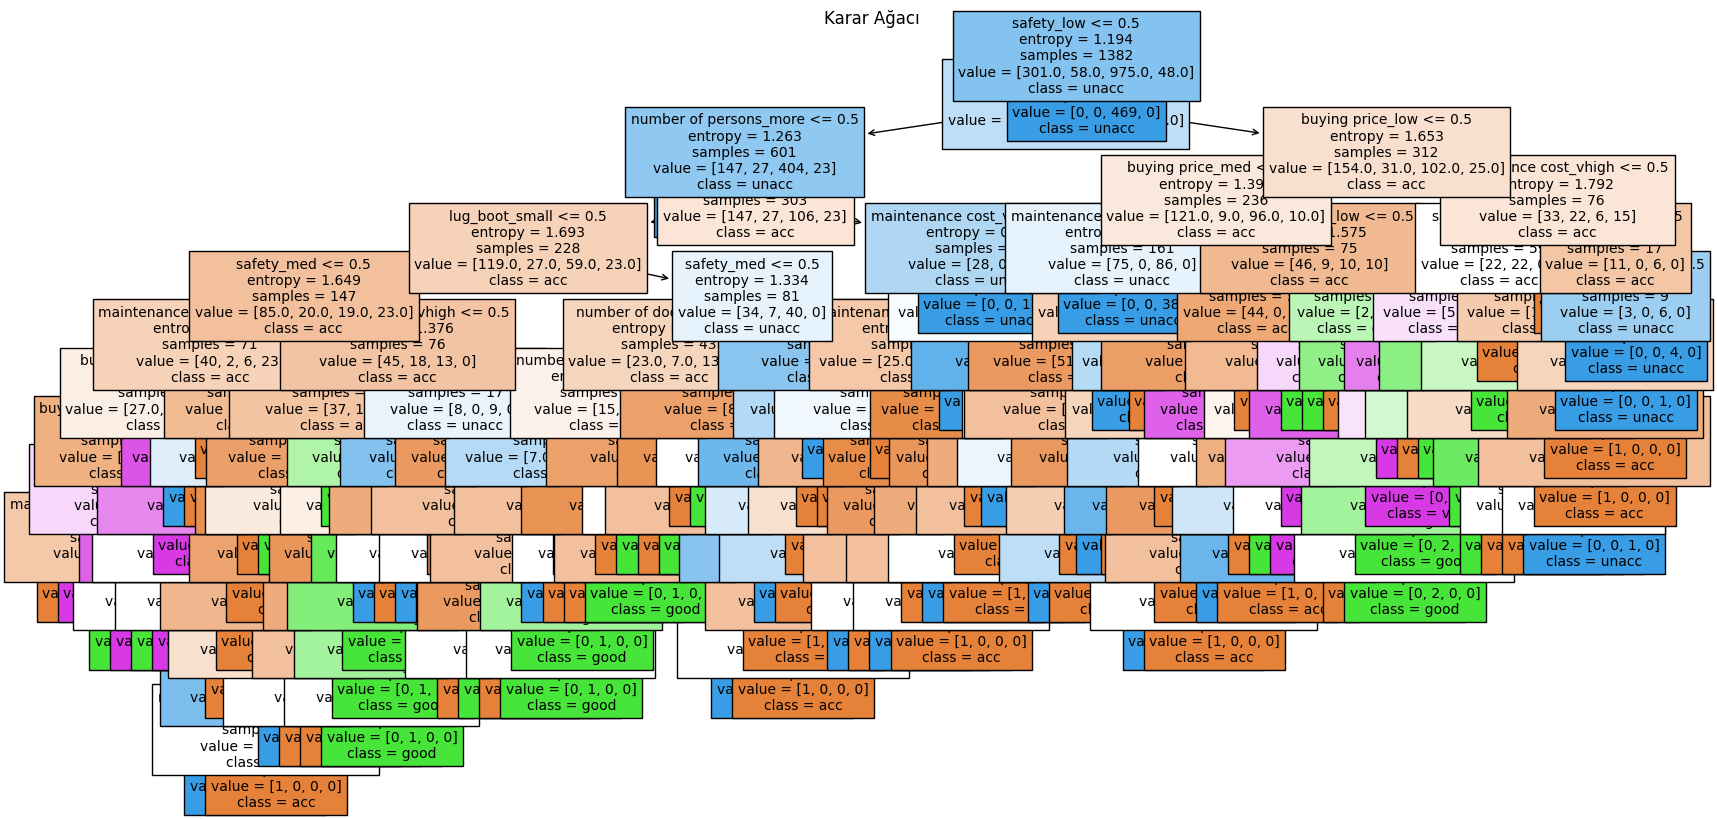

In [23]:
plot_model_tree(model_default)

In [24]:
print_rules(model_default)

Kurallar:
|--- safety_low <= 0.50
|   |--- number of persons_4 <= 0.50
|   |   |--- number of persons_more <= 0.50
|   |   |   |--- class: unacc
|   |   |--- number of persons_more >  0.50
|   |   |   |--- buying price_vhigh <= 0.50
|   |   |   |   |--- lug_boot_small <= 0.50
|   |   |   |   |   |--- safety_med <= 0.50
|   |   |   |   |   |   |--- maintenance cost_vhigh <= 0.50
|   |   |   |   |   |   |   |--- buying price_low <= 0.50
|   |   |   |   |   |   |   |   |--- buying price_med <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: acc
|   |   |   |   |   |   |   |   |--- buying price_med >  0.50
|   |   |   |   |   |   |   |   |   |--- maintenance cost_low <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- maintenance cost_med <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: acc
|   |   |   |   |   |   |   |   |   |   |--- maintenance cost_med >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: vgood
|   |   |   |   |   |   |   |   |   |--- main

Varsayılan modelin sonuçları iyi çıksa da sonucu potansiyel olarak iyileştirmeye çalıştım. Burada max_depth'i daha düşük tutarak muhtemel bir overfitting sorununun önüne geçebileceğimi düşündüm. Ayrıca max_depth'i düşük tutarak ağacın görünümü ve kuralları daha basit oldu, böylece bizim için modeli anlaması da kolaylaştı. Öncelikle görsel anlamda daha anlamlı bir ağaç görmek istediğim için max_depth 4 verdim.

In [52]:
model_md = create_model(max_depth=4)
accuracy_md = evaluate_model(model_md)
print(f"Max depth 4 olan modelin doğruluğu: {accuracy_md:.2f}")

Max depth 4 olan modelin doğruluğu: 0.82


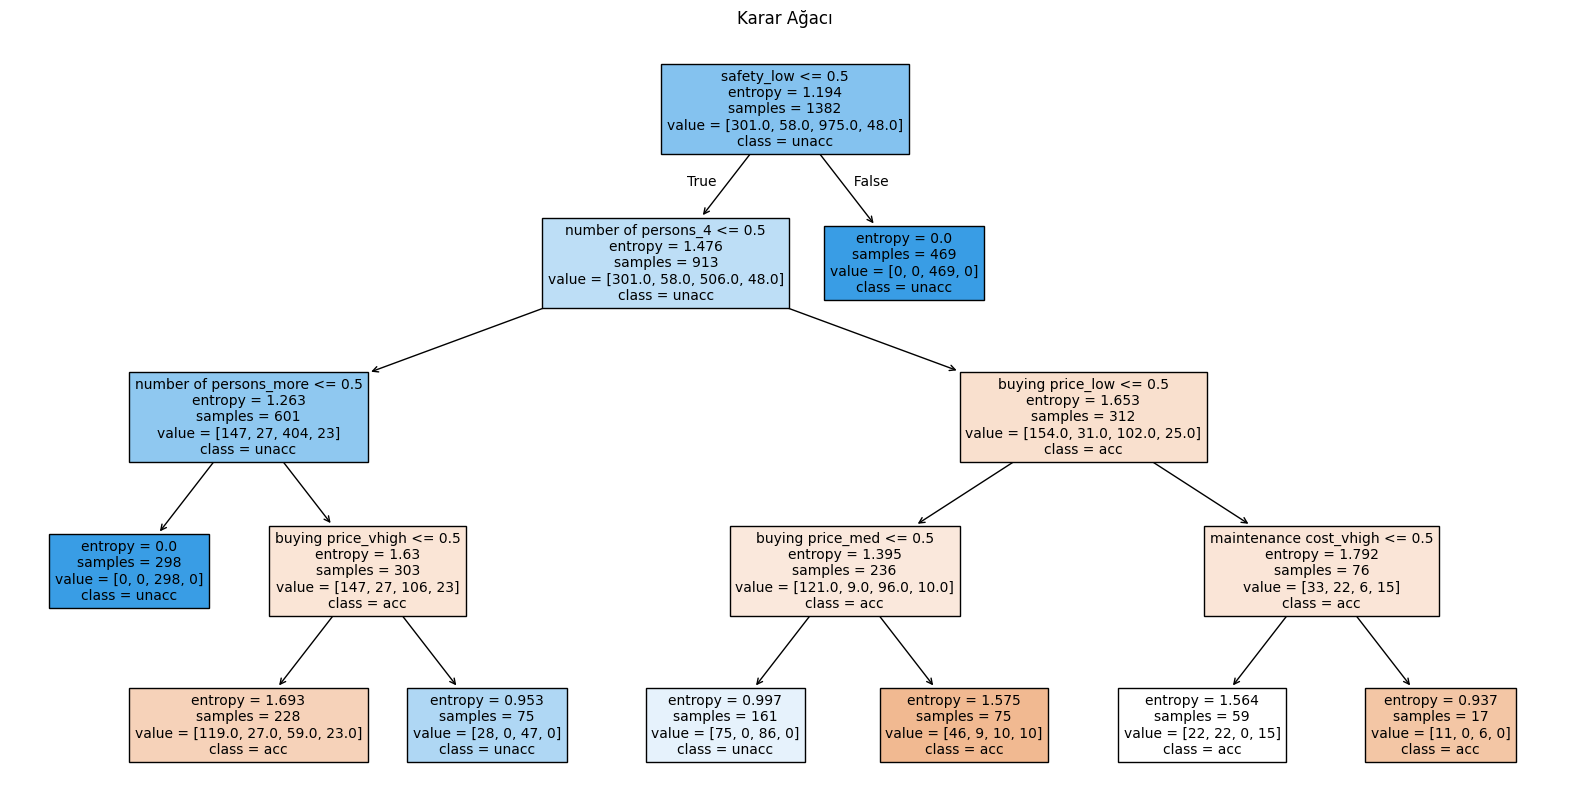

In [53]:
plot_model_tree(model_md)

In [54]:
print_rules(model_md)

Kurallar:
|--- safety_low <= 0.50
|   |--- number of persons_4 <= 0.50
|   |   |--- number of persons_more <= 0.50
|   |   |   |--- class: unacc
|   |   |--- number of persons_more >  0.50
|   |   |   |--- buying price_vhigh <= 0.50
|   |   |   |   |--- class: acc
|   |   |   |--- buying price_vhigh >  0.50
|   |   |   |   |--- class: unacc
|   |--- number of persons_4 >  0.50
|   |   |--- buying price_low <= 0.50
|   |   |   |--- buying price_med <= 0.50
|   |   |   |   |--- class: unacc
|   |   |   |--- buying price_med >  0.50
|   |   |   |   |--- class: acc
|   |   |--- buying price_low >  0.50
|   |   |   |--- maintenance cost_vhigh <= 0.50
|   |   |   |   |--- class: acc
|   |   |   |--- maintenance cost_vhigh >  0.50
|   |   |   |   |--- class: acc
|--- safety_low >  0.50
|   |--- class: unacc



Ağaç artık daha küçük olduğu için bizim için ağacı incelemesi daha kolay bir hale geldi ancak modelin test doğruluğu 89%'dan 82%'ye geriledi. Merak ettiğim bir durum ise farklı max_depth değerleri verirsem test doğruluğunu artırıp artıramayacağımı görmekti. Bunu da aşağıda yaptım.

Max depth 3 olan modelin doğruluğu: 0.80
Max depth 4 olan modelin doğruluğu: 0.82
Max depth 5 olan modelin doğruluğu: 0.84
Max depth 6 olan modelin doğruluğu: 0.84
Max depth 7 olan modelin doğruluğu: 0.83
Max depth 8 olan modelin doğruluğu: 0.87
Max depth 9 olan modelin doğruluğu: 0.91
Max depth 10 olan modelin doğruluğu: 0.89
Max depth 11 olan modelin doğruluğu: 0.89
Max depth 12 olan modelin doğruluğu: 0.89
Max depth 13 olan modelin doğruluğu: 0.89
Max depth 14 olan modelin doğruluğu: 0.89


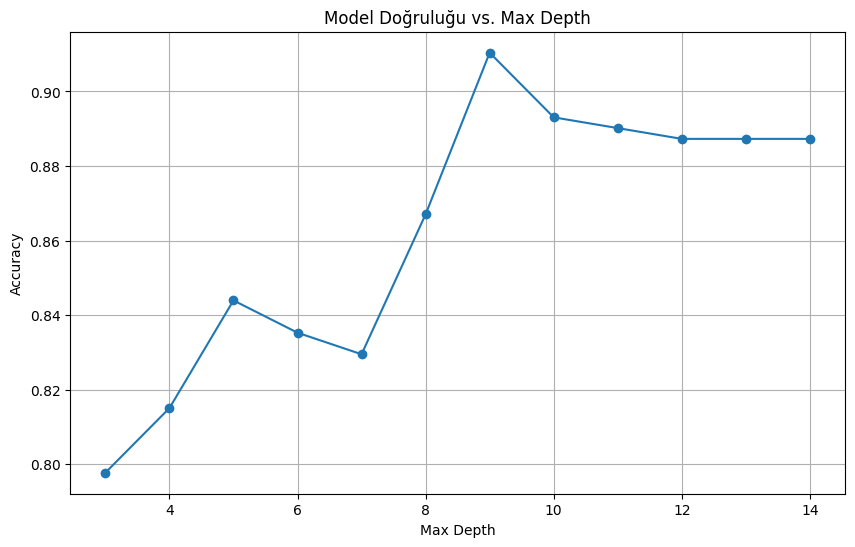

In [58]:
model_per_md = {}
acc_per_md = {}

for max_depth in range(3, 15):
  model = create_model(max_depth=max_depth)
  accuracy = evaluate_model(model)
  print(f"Max depth {max_depth} olan modelin doğruluğu: {accuracy:.2f}")
  model_per_md[max_depth] = model
  acc_per_md[max_depth] = accuracy

# plot
plt.figure(figsize=(10, 6))
plt.plot(acc_per_md.keys(), acc_per_md.values(), marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Model Doğruluğu vs. Max Depth')
plt.grid(True)
plt.show()

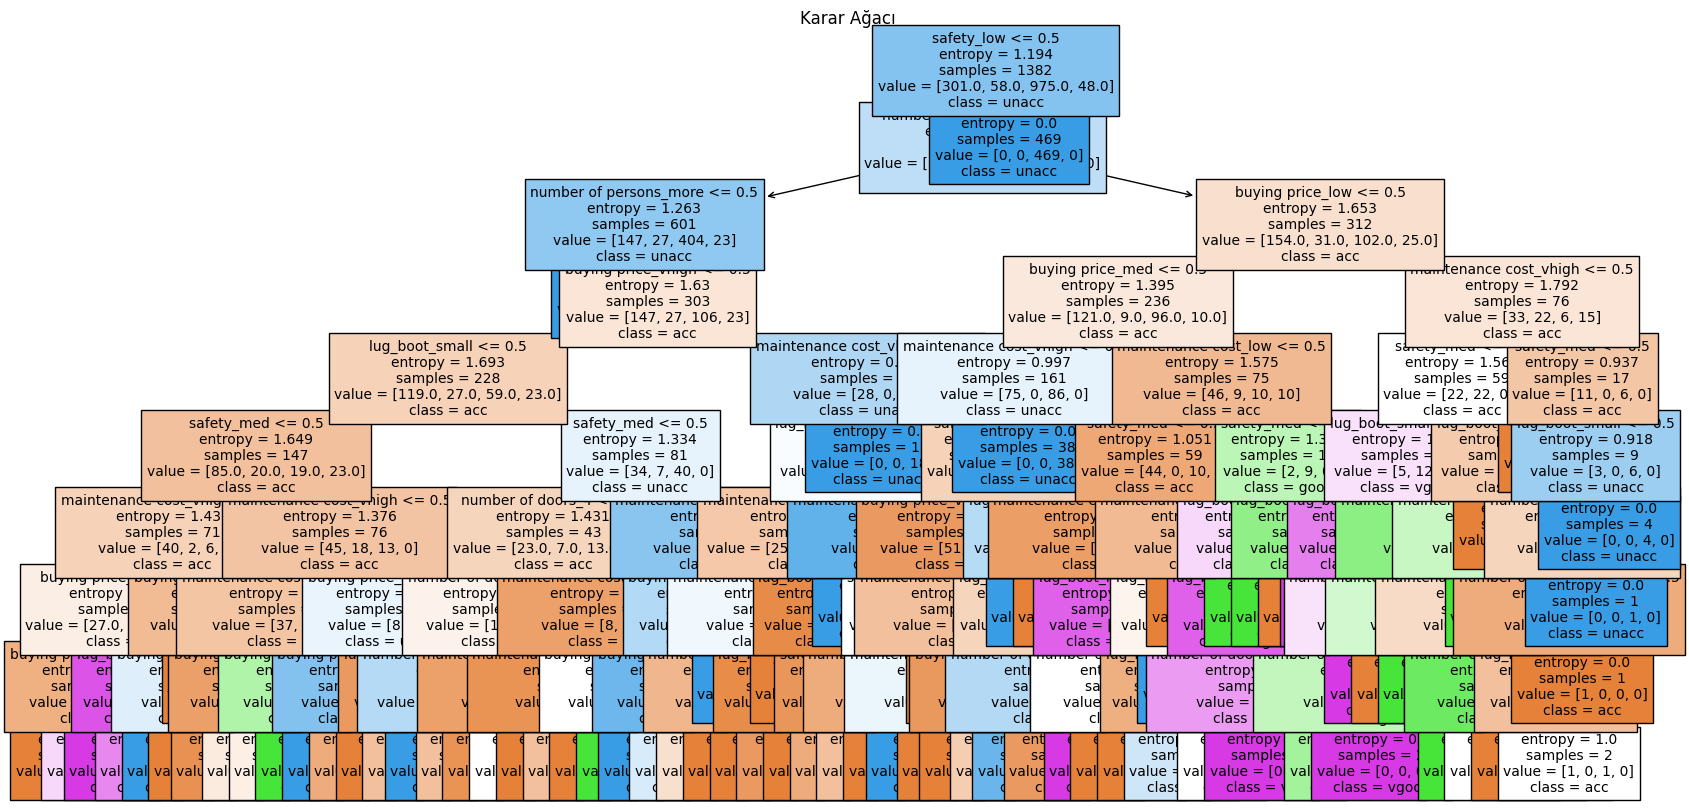

In [59]:
plot_model_tree(model_per_md[9])

In [60]:
print_rules(model_per_md[9])

Kurallar:
|--- safety_low <= 0.50
|   |--- number of persons_4 <= 0.50
|   |   |--- number of persons_more <= 0.50
|   |   |   |--- class: unacc
|   |   |--- number of persons_more >  0.50
|   |   |   |--- buying price_vhigh <= 0.50
|   |   |   |   |--- lug_boot_small <= 0.50
|   |   |   |   |   |--- safety_med <= 0.50
|   |   |   |   |   |   |--- maintenance cost_vhigh <= 0.50
|   |   |   |   |   |   |   |--- buying price_low <= 0.50
|   |   |   |   |   |   |   |   |--- buying price_med <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: acc
|   |   |   |   |   |   |   |   |--- buying price_med >  0.50
|   |   |   |   |   |   |   |   |   |--- class: vgood
|   |   |   |   |   |   |   |--- buying price_low >  0.50
|   |   |   |   |   |   |   |   |--- lug_boot_med <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: vgood
|   |   |   |   |   |   |   |   |--- lug_boot_med >  0.50
|   |   |   |   |   |   |   |   |   |--- class: vgood
|   |   |   |   |   |   |--- maintenance cost_vhi

# **Sonuçlar**
1. Veriseti eğitim ve test olarak %80 ve %20 oranında bölündü.
2. Karar ağacı modelleri `entropy` kriterine göre eğitildi.
3. Modelin farklı max_depth değerlerinde test doğruluğu ölçüldü. En yüksek test doğruluğu max_depth=9 değerinde 91% olarak görüldü.
4. Ağaç görselleştirildi ve oluşturulan kurallarla birlikte verildi.